In [1]:
import math
import numpy as np
from numpy import sin, cos, tan, arctan2, arcsin
from numpy.linalg import inv, norm
import matplotlib as mpl
from scipy import integrate
%matplotlib inline
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

ModuleNotFoundError: No module named 'pyquaternion'

In [2]:
# Transformation matrix to map angular velocities from inertial frame to the body frame
def transformation(angles):
    # Unpack angles
    phi = angles[0, 0]   
    theta = angles[1, 0]
    psi = angles[2, 0]
    
    W = np.array([[1.0, 0.0, -sin(theta)], 
                  [0.0, cos(phi), cos(theta)*sin(phi)], 
                  [0.0, -sin(phi), cos(theta)*cos(phi)]])    
    return W

In [3]:
# Transformation matrix to map angular velocities from body frame to the inertial frame
def inverse_transformation(angles):
    # Unpack angles
    phi = angles[0, 0]   
    theta = angles[1, 0]
    psi = angles[2, 0]
    

    invW = np.array([[1.0, sin(phi)*tan(theta), cos(phi)*tan(theta)], 
                     [0.0, cos(phi), -sin(phi)],
                     [0.0, sin(phi)/cos(theta), cos(phi)/cos(theta)]])    
    return invW

In [4]:
# Rotation matrix with euler angles
def rotation(angles):
    # Unpack angles
    phi = angles[0, 0]   
    theta = angles[1, 0]
    psi = angles[2, 0]
    
    # Form the rotation matrix    
    R = np.array([[cos(psi)*cos(theta), cos(psi)*sin(theta)*sin(phi)-sin(psi)*cos(phi), cos(psi)*sin(theta)*cos(phi)+sin(psi)*sin(phi)], 
                 [sin(psi)*cos(theta), sin(psi)*sin(theta)*sin(phi)+cos(psi)*cos(phi), sin(psi)*sin(theta)*cos(phi)-cos(psi)*sin(phi)],
                 [-sin(theta), cos(theta)*sin(phi), cos(theta)*cos(phi)]])
    
    return R

In [5]:
# Thrust in body frame
def thrust(inputs, k):
    # Form the thrust vector
    T = np.array([[0.0], [0.0], [k*np.sum(inputs)]])
    return T

In [6]:
# Torques in body frame
def torques(inputs, L, b, k):
    # Form torque vector
    tau = np.array([[L*k*(inputs[0, 0]-inputs[2, 0])], 
                    [L*k*(inputs[1, 0]-inputs[3, 0])],
                    [b*(inputs[0, 0]-inputs[1, 0]+inputs[2, 0]-inputs[3, 0])]])    
    return tau


In [7]:
def state_update(states, inputs, params, dt):
    # Unpack states
    x = states[0:3]
    xdot = states[3:6]
    theta = states[6:9]
    thetadot = states[9:12]
    
    # Unpack parameters
    g = params['g']
    m = params['m']
    L = params['L']
    k = params['k']
    b = params['b']
    I = params['I']
    kd = params['kd']
    
    # Map angular velocities from inertial frame to the body frame 
    W = transformation(theta)
    omega = np.dot(W, thetadot) 
    
    # Euler angle to quaternion (performs also normalization)
    quat = eul2quat(theta) 
    # Calculate rotation matrix with Euler angle
    R = rotation(theta) 
    
    # Calculate rotation matrix with quaternion    
    # R = quaternionRotation(quat)
    
    # Calculate thrust in inertial frame
    T = np.dot(R, thrust(inputs, k))
    
    # Define gravity vector
    gravity = np.array([[0.0], [0.0], [-g]])
    
    # Calculate translational drag force
    Fd = -kd*xdot
    
    # Calculate translational acceleration
    xdotdot = gravity + 1/m*(T + Fd)
    
    # Calculate torques
    tau = torques(inputs, L, b, k)
 
    # Calculate angular acceleration in body frame    
    omegadot = np.dot(inv(I), (tau-np.cross(omega, np.dot(I, omega), axis=0)))
            
    quatdot = quatDerivative(omega, quat)
       
    # State update
    x = x + dt*xdot
    xdot = xdot + dt*xdotdot
    omega = omega + dt*omegadot
    quat = quat + dt*quat    
    theta = quat2eul(quat)

    # Stack up states for return
    X = np.vstack((x, xdot, theta, omega))
    return X

In [8]:
def simulation(mode='offline', tstart=0, tstop=30, dt=0.01):
    # Environmental constants
    g = 9.81                             # gravity constant [m/s**2]

    # Physical constants
    m = 0.5                              # mass [kg]
    L = 0.25                             # Length from rotor to center of gravity
    k = 3e-6                             # lift coefficient [N/(m/s)**2]
    b = 1e-7                             # rotational drag coefficient [Nms**2]
    I = np.diag([5e-3, 5e-3, 10e-3])     # inertia matrix [kgm**2]
    kd = 0.25                            # translational drag coefficient [N/(m/s)**2]      
    
    # Define initial value for states (x, xdot, theta, thetadot)
    X = np.array([[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]])
    
    # Gyroscope measures omega (body frame angular velocity)
    # We might want to control theta or thetadot, i.e. the inertial frame angle and angular velocity. 
    # In this case we need to map body frame rates to inertial frame rates, which requires a transformation matrix
    # that is singular for pitch angle 90 degrees (theta_y = 90), the so called Gimbal lock. 
    # We need to perform this transformation using quaternions.
    # If we make sure that we will never be operating the quadcopter at pitch angle 90 degrees, we can be happy with Euler angles.
    # Even if we use quaternions we cannot still uniquely define the sway and yaw angle at Gimbal lock. The only way to do that
    # is to use a second Gyro with different orientation. The quaternions are just a mathematical trick to perform the transformation
    # avoiding the singularity problem that exist with Euler angles.
    
    Ustatic = np.full((4, 1), m*g/k/4)
    # Pack parameters by dictionary
    params = {'g': g, 'm': m, 'L': L, 'k': k, 'b': b, 'I': I, 'kd': kd}
     
    # Calculate the number of iterations
    if mode == 'offline':
        N = int((tstop-tstart)/dt+1)              # number of time samples [] 
    elif mode == 'online':
        N = inf                              # infinite loop []    
    
    # Define vectors where simulation data will be stored
    Xvec = np.copy(X)
    Uvec = np.copy(Ustatic)
    ind = 0

    while ind < N-1:        
        ts = ind*dt

        if ts < 10: # Start with a (step) impulse into a decay
            # Define input vector as a 1/ts*ts+dt 1 decay
            U = (1 + 0.05/(ts**2+dt))*Ustatic
        else:
            # Define input vector (squared angular velocity of rotors)
            U = (1 + 0.2*sin(2*np.pi*ts/((tstop-tstart)*0.2)-np.pi/2))*Ustatic 

        X = state_update(X, U, params, dt)
        Xvec = np.hstack((Xvec, X))
        Uvec = np.hstack((Uvec, U))
        ind = ind + 1
    
    t = np.linspace(tstart, tstop, N)      # time array [s]
        
    return Xvec, Uvec, t

In [9]:
# Multiplies two quaternions
def multiplyQuaternion(p, q):
    Q = np.array([[p[0, 0], -p[1, 0], -p[2, 0], -p[3, 0]],
                  [p[1, 0],  p[0, 0], -p[3, 0],  p[2, 0]],
                  [p[2, 0],  p[3, 0],  p[0, 0], -p[1, 0]],
                  [p[3, 0], -p[2, 0],  p[1, 0],  p[0, 0]]])
    return np.dot(Q, q)

In [10]:
# Normalizes a quaternion
def normQuaternion(q):
    return np.sqrt(np.sum(q**2))

In [11]:
def conjQuaternion(q):
    p = np.copy(q)
    p[1:4, 0] = -p[1:4, 0]
    return p

In [12]:
# Takes inverse of a quaternion
def invQuaternion(q):
    return conjQuaternion(q)/normQuaternion(q)

In [13]:
# Form the rotation matrix using quaternions
def quaternionRotation(q):
    q0square = q[0, 0]**2
    q1square = q[1, 0]**2
    q2square = q[2, 0]**2
    q3square = q[3, 0]**2
    q1q2 = q[1, 0]*q[2, 0]
    q0q3 = q[0, 0]*q[3, 0]
    q1q3 = q[1, 0]*q[3, 0]
    q0q2 = q[0, 0]*q[2, 0]
    q2q3 = q[2, 0]*q[3, 0]
    q0q1 = q[0, 0]*q[1, 0]
    
    R = np.array([[1-2*(q2square+q3square), 2*(q1q2-q0q3), 2*(q0q2+q1q3)], 
                  [2*(q1q2+q0q3), 1-2*(q1square+q3square), 2*(q2q3-q0q1)], 
                  [2*(q1q3-q0q2), 2*(q0q1+q2q3), 1-2*(q1square+q2square)]])
    return R

In [14]:
# Conversion from Euler angles to Quaternions (ZYX)
def eul2quat(angles):
    # Unpack angles
    
    c = cos(angles/2)
    s = sin(angles/2)

    q = np.array([[c[0, 0]*c[1, 0]*c[2, 0]+s[0, 0]*s[1, 0]*s[2, 0]],
                  [s[0, 0]*c[1, 0]*c[2, 0]-c[0, 0]*s[1, 0]*s[2, 0]], 
                  [c[0, 0]*s[1, 0]*c[2, 0]+s[0, 0]*c[1, 0]*s[2, 0]], 
                  [c[0, 0]*c[1, 0]*s[2, 0]-s[0, 0]*s[1, 0]*c[2, 0]]])
    
    return q

In [15]:
def quatDerivative(omega, q):
    omegaQuat = np.vstack((0.0, omega))
    qdot = -0.5*multiplyQuaternion(omegaQuat, q) # hand quaternion derivative, i.e. counterclockwise rotation is considered to be
                                                 # positive            
    return qdot

In [16]:
# Conversion from Quaternion to Euler Angles (ZYX)
def quat2eul(q):
    # Normalize quaternion
    q = q/normQuaternion(q)
    
    # Pre-compute repeating operations
    q2square = q[2, 0]**2;
    
    arcsinInput = np.clip(2*(q[0, 0]*q[2, 0]-q[3, 0]*q[1, 0]), -1, 1);  # bound inputs to asin between (-1, 1), since values > 1 produce complex results
                                                    # Since the quaternion is of unit length, this should never happen, however due to 
                                                    # numerical imprecision, this can happen
    angles = np.array([[arctan2(2*(q[0, 0]*q[1, 0]+q[2, 0]*q[3, 0]), 1-2*(q[1, 0]**2+q2square))], 
                       [arcsin(arcsinInput)], 
                       [arctan2(2*(q[0, 0]*q[3, 0]+q[1, 0]*q[2, 0]), 1-2*(q2square+q[3, 0]**2))]])
    
    return angles

In [17]:
X, U, t = simulation()

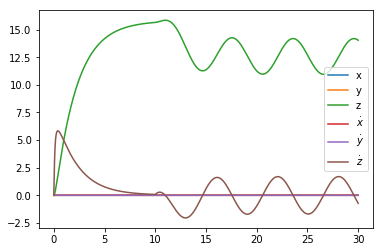

In [18]:
plt.plot(t, X[0, :], label='x')
plt.plot(t, X[1, :], label='y')
plt.plot(t, X[2, :], label='z')
plt.plot(t, X[3, :], label='$\dot{x}$')
plt.plot(t, X[4, :], label='$\dot{y}$')
plt.plot(t, X[5, :], label='$\dot{z}$')
plt.legend()

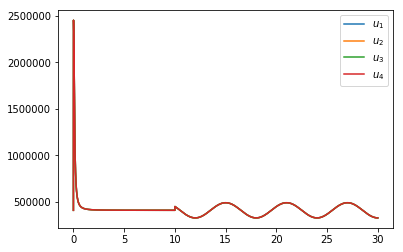

In [19]:
plt.plot(t, U[0, :], label='$u_1$')
plt.plot(t, U[1, :], label='$u_2$')
plt.plot(t, U[2, :], label='$u_3$')
plt.plot(t, U[3, :], label='$u_4$')
plt.legend()

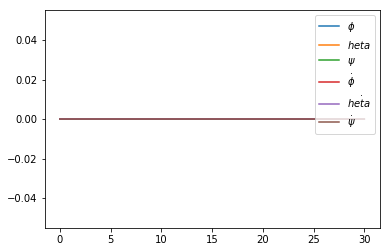

In [20]:
plt.plot(t, X[6, :], label='$\phi$')
plt.plot(t, X[7, :], label='$\theta$')
plt.plot(t, X[8, :], label='$\psi$')
plt.plot(t, X[9, :], label='$\dot{\phi}$')
plt.plot(t, X[10, :], label='$\dot{\theta}$')
plt.plot(t, X[11, :], label='$\dot{\psi}$')
plt.legend()

In [21]:
quat = eul2quat(np.array([[np.pi/6], [np.pi/2.1], [np.pi/3]]))

In [22]:
quat2eul(quat)

array([[0.52359878],
       [1.4959965 ],
       [1.04719755]])